In [ ]:
import kagglehub
trainingdatapro_gender_detection_and_classification_image_dataset_path = kagglehub.dataset_download('trainingdatapro/gender-detection-and-classification-image-dataset')

print('Data source import complete.')
# https://www.kaggle.com/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/data


Data source import complete.


In [ ]:
import random
import numpy as np
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
#======================================
import os
import shutil
import random
from os import listdir
from os.path import isfile, join
#=====================================
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
#=====================================
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
#=====================================
from tqdm.auto import tqdm

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


<div class="alert alert-success" style="background-color: #3498db; color: #fff; text-align: center; border: 2px solid #2980b9; border-radius: 10px; padding: 15px; position: relative;">
    <h1 style="font-family: 'Arial', sans-serif; font-size: 24px; margin-bottom: 10px;">Классификация пола людей</h1>
    <h1 style="font-family: 'Arial', sans-serif; font-size: 24px;">Classification of gender of people</h1>
</div>



<div class="alert alert-success" style="background-color: #3498db; color: #fff; text-align: center; border: 2px solid #2980b9; border-radius: 10px; padding: 15px; position: relative;">
    <h1 style="font-family: 'Arial', sans-serif; font-size: 24px; margin-bottom: 10px;">Объявление переменных и констант</h1>
    <h1 style="font-family: 'Arial', sans-serif; font-size: 24px;">Declaration of Variables and Constants</h1>
</div>

## Declaration of Variables and Constants /Объявление переменных и констант


In [ ]:
Base_path_to_datas_to_train='/kaggle/input/gender-detection-and-classification-image-dataset/train'
Base_path_to_datas_to_val='/kaggle/input/gender-detection-and-classification-image-dataset/test'
#=======================================================================
Bath_size=8
drobl = Bath_size // 2

Learn_rate=0.001
Num_epoch=15
Size_of_img=224
Num_workers=0
PIN_MEMORY=False
#=======================================================================
clas_of_img={0:'Men',
            1:'Women',

}
#=======================================================================
results_dict = {}
modeli=[]
#=======================================================================
torch.manual_seed(5017)
torch.cuda.manual_seed(5017)


<div class="alert alert-success" style="background-color: #3498db; color: #fff; text-align: center; border: 2px solid #2980b9; border-radius: 10px; padding: 15px; position: relative;">
    <h1 style="font-family: 'Arial', sans-serif; font-size: 24px; margin-bottom: 10px;">Создание функций для работы</h1>
    <h1 style="font-family: 'Arial', sans-serif; font-size: 24px;">Creating Functions to Work</h1>
</div>


## Creating Functions to Work /Создание функций для работы

In [ ]:
def visual_the_sample(Data_dir,indx,_transform=None):
    dataset = Custom_dataset(data_dir=Data_dir,
                          transform=_transform)
    image, label = dataset[indx]
    print(clas_of_img[label])
    image = TF.to_pil_image(image)
    #----------------------------------------------
    plt.imshow(image)
    plt.axis('off')
    plt.show()



#=====================================================================================
def get_loaders(BATCH_SIZE,
                Data_dir_train,
                Data_dir_test,
                Num_workers,
                PIN_MEMORY,
                _transform_train=None,
                _transform_test=None,
                split_val=[0.7,0.2,0.1]):


    train_ds = Custom_dataset(data_dir=Data_dir_train,
                          transform=_transform_train)

    test_ds = Custom_dataset(data_dir=Data_dir_test,
                          transform=_transform_test)

    data_indices_for_train_val=list(range(0,len(train_ds)))

    train_indices,val_indices  = train_test_split(data_indices_for_train_val, test_size=split_val[1], random_state=42)

    print('Number of train samples :',len(train_indices))
    print('Number of val samples :',len(val_indices))
    print('Number of test samples :',len(test_ds))






    valid_sampler=SubsetRandomSampler(val_indices)
    train_sampler=SubsetRandomSampler(train_indices)

    #Так как мы имеем отдельную папку под тестирование, лучше выделить больше для тренировки
    #Так как мы имеем отдельную папку под тестирование, лучше выделить больше для тренировки
    train_loader=DataLoader(train_ds,batch_size=BATCH_SIZE,num_workers=Num_workers,pin_memory=PIN_MEMORY,sampler=train_sampler) #,sampler=train_sampler
    validation_loader=DataLoader(train_ds,batch_size=BATCH_SIZE,num_workers=Num_workers,pin_memory=PIN_MEMORY,sampler=valid_sampler)
    test_loader=DataLoader(test_ds,batch_size=BATCH_SIZE,num_workers=Num_workers,pin_memory=PIN_MEMORY,shuffle=True)





    return train_loader,validation_loader,test_loader

In [ ]:
def get_resnet_18(num_classes,array_for_model):

    resnet_18 = models.resnet18(pretrained=True)


    for param in resnet_18.parameters():
        param.requires_grad = False


    resnet_18.fc = CustomClassifier_Custom(resnet_18.fc.in_features,array_for_model, num_classes)


    return resnet_18
#================================================================================
def get_resnet_50(num_classes,array_for_model):

    resnet_50 = models.resnet50(pretrained=True)


    for param in resnet_50.parameters():
        param.requires_grad = False


    resnet_50.fc = CustomClassifier_Custom(resnet_50.fc.in_features,array_for_model, num_classes)


    return resnet_50
#================================================================================
def get_resnet_101(num_classes,array_for_model):

    resnet_101 = models.resnet101(pretrained=True)


    for param in resnet_101.parameters():
        param.requires_grad = False


    resnet_101.fc = CustomClassifier_Custom(resnet_101.fc.in_features,array_for_model, num_classes)


    return resnet_101

In [ ]:
train_transform=A.Compose(
    [
        A.Resize(height=Size_of_img,width=Size_of_img),
        A.HorizontalFlip(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.OneOf([
     A.GaussNoise(var_limit=(10, 50), p=0.5),
], p=0.2),

        A.Normalize(
            mean=[0, 0, 0],

            std=[1.0,1.0,1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2(),

    ],
    is_check_shapes=False
)


test_transform=A.Compose(
    [
        A.Resize(height=Size_of_img,width=Size_of_img),


        A.Normalize(
            mean=[0, 0, 0],

            std=[1.0,1.0,1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2(),

    ],
    is_check_shapes=False
)




class CustomClassifier_Custom(nn.Module):
    def __init__(self, in_features,weights_arr, num_classes):
        super(CustomClassifier_Custom, self).__init__()
        self.weights_arr = weights_arr
        #-----------------------------------------------------
        self.fc1 = nn.Linear(in_features, self.weights_arr[0])
        self.bn1 = nn.BatchNorm1d(self.weights_arr[0])
        #-----------------------------------------------------
        if (len(self.weights_arr) >= 2):
            self.layer_custom = nn.Sequential()
            for i in range(len(self.weights_arr)-1):
                self.layer_custom.add_module(f"conv_{i}", nn.Linear(self.weights_arr[i],self.weights_arr[i+1]))
                self.layer_custom.add_module(f"bn_{i}", nn.BatchNorm1d(self.weights_arr[i + 1]))
                self.layer_custom.add_module(f"relu_{i}",nn.ReLU())
                self.layer_custom.add_module(f"drop_{i}",nn.Dropout(p=0.5))

        #-----------------------------------------------------
        self.Dropuot = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(self.weights_arr[-1], num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.Dropuot(x)
        if (len(self.weights_arr) >= 2):
            x = self.layer_custom(x)
        x = self.fc2(x)
        return x

<ipython-input-6-62c6b22fc2c3>:8: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.5),


In [ ]:
def train_(loader,model,optimizer,loss_fn,scaler,auto_cast=True):
    loop=tqdm(loader)
    total_loss = 0.0
    model.train()
    for batch_indx,(data,targets) in enumerate(loop):
        data=data.to(device=device)
        targets=targets.float().to(device=device)#.unsqueeze(1)
        #train
        if auto_cast:
            with torch.cuda.amp.autocast():

                pred=model(data)
                loss=loss_fn(pred,targets)



            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)

            scaler.update()

            loop.set_postfix(loss=loss.item())

        else:
            optimizer.zero_grad()
            targets=targets.long()

            outputs = model(data)


            loss = loss_fn(outputs, targets)


            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    print(f'on Epoch  Loss: {total_loss/len(train_loader):.4f}')

#=======================================================================

def take_the_good_modell(accuracy,recall,epoch,model,model_name,thread_acc=0.7,thread_recc=0.7):
    if accuracy>thread_acc and recall>thread_recc:
         torch.save(model.state_dict(), f"pytorch_{model_name}-e{epoch}.pth")

In [ ]:
def check_accuracy(loader, model, device="cuda",type_of_train='train'):
    num_correct = 0
    num_total = 0
    num_true_positives = 0
    num_false_negatives = 0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            preds = torch.sigmoid(model(x))

            _, preds = torch.max(preds, dim=1, keepdim=True)
            preds = preds.float()

            num_correct += torch.eq(preds, y.view(-1, 1)).sum().item()

            num_true_positives += torch.eq((preds == 1) , (y == 1).view(-1, 1)).sum().item()

            num_false_negatives += torch.eq((preds == 0) , (y == 1).view(-1, 1)).sum().item()



    accuracy = num_correct / (len(loader)*Bath_size)

    recall = num_true_positives / (num_true_positives + num_false_negatives)

    print(f"Точность на {type_of_train}/(Accuracy on {type_of_train}): {accuracy:.4f}")
    print(f"Полнота на {type_of_train}/(Recall on {type_of_train}): {recall:.4f}")



    model.train()

    return accuracy,recall

#=======================================================================
def check_visual_res(loader,model,ny=4,nx=4,s_y=5,s_x=5):
    images,labels=next(iter(loader))
    images = images.to(device)
    fig,axis=plt.subplots(ny,nx,figsize=(s_y,s_x))
    model.eval()
    for i,ax in enumerate(axis.flat):
        with torch.no_grad():
            preds = torch.sigmoid(model(images))

            _, preds = torch.max(preds, dim=1, keepdim=True)
            preds = preds.float()

            npimg = images[i].cpu().detach().numpy()

            npimg=np.transpose(npimg,(1,2,0))
            label=preds[i]
            targ=labels[i]
            ax.imshow(npimg)
            res=clas_of_img[label.item()]==clas_of_img[targ.item()]
            ax.set(title=f'{res} Label')


def Got_the_matrix_predictions(loader,model,ny=4,nx=4,s_y=5,s_x=5):

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            preds = torch.sigmoid(model(x))

            _, preds = torch.max(preds, dim=1, keepdim=True)
            preds = preds.float()

            cm = confusion_matrix(y, preds)

In [ ]:
def train_for_epoch(Num_epoch,
                    model,
                    optimizer,
                    loss_function,
                    scheduler,
                    train_loader,
                    validation_loader,
                    test_loader,
                    save_dict,
                    model_name = '',
                    thresh = 0.9,
                    alternative_thresh = 0.85):
    modeli.append(model_name)
    for epoch in range(Num_epoch):


        train_(train_loader,model,optimizer,loss_function,scaler,auto_cast=False)

        #----------------------------------------------------------------------

        temp_accuracy_train,temp_recall_train = check_accuracy(train_loader,model,device=device,type_of_train='train')
        temp_accuracy_val,temp_recall_val = check_accuracy(validation_loader,model,device=device,type_of_train='valid')


        #----------------------------------------------------------------------
        take_the_good_modell(temp_accuracy_val,temp_recall_val,epoch,model,model_name)
        test_acc_test,test_recc_test = check_accuracy(test_loader,model,device=device,type_of_train='test')

        save_dict[model_name+f'1_epoch_{epoch}'] = {
            'train': [temp_accuracy_train, temp_recall_train],
            'valid': [temp_accuracy_val, temp_recall_val],
            'test': [test_acc_test, test_recc_test]
        }
        scheduler.step()
        print(f'^^^^^^^^^^^^^^^^^^^^^^^^^epoch={epoch}/{Num_epoch}^^^^^^^^^^^^^^^^^^^^^^^^^')
        if (test_acc_test > thresh) and (test_recc_test> thresh) :
            print(f'Test accuracy reached {test_acc_test * 100:.2f}%, stopping training.')
            torch.save(model.state_dict(), f'{model_name}_epoch_{epoch}_.pth')
            break

        if (test_acc_test > alternative_thresh) and (test_recc_test> alternative_thresh) :
            print(f'Test accuracy reached {test_acc_test * 100:.2f}%, stopping training.')
            torch.save(model.state_dict(), f'{model_name}_epoch_{epoch}_.pth')
            break




    check_visual_res(test_loader,model,ny=int(2),nx=int(drobl),s_y=20,s_x=20)




def draw_graph(results_dict,modeli):
    models = list(results_dict.keys())
    #-----------------------------------------------------------------------
    train_accuracy = [results_dict[model]['train'][0] for model in models]
    train_recall = [results_dict[model]['train'][1] for model in models]
    valid_accuracy = [results_dict[model]['valid'][0] for model in models]
    valid_recall = [results_dict[model]['valid'][1] for model in models]
    test_accuracy = [results_dict[model]['test'][0] for model in models]
    test_recall = [results_dict[model]['test'][1] for model in models]
    #-----------------------------------------------------------------------
    plt.figure(figsize=(20, 35))
    #-----------------------------------------------------------------------
    plt.subplot(3, 1, 1)
    for indx, model in enumerate(modeli):


        plt.plot(range(Num_epoch), train_accuracy[indx*Num_epoch:(indx+1)*Num_epoch], label=f'Точность(accuracy) (тренировка), модель- {model}')
        plt.plot(range(Num_epoch), train_recall[indx*Num_epoch:(indx+1)*Num_epoch], label=f'Полнота(recall) (тренировка), модель- {model}')
    plt.title('Точность(accuracy) и полнота(recall) (тренировка)')
    plt.xlim(0,Num_epoch)
    plt.ylim(0.5,1)
    plt.xlabel('Модели')
    plt.ylabel('Метрики')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(modeli))
    plt.grid(True)
    #-----------------------------------------------------------------------
    plt.subplot(3, 1, 2)

    for indx, model in enumerate(modeli):



        plt.plot(range(Num_epoch), valid_accuracy[indx*Num_epoch:(indx+1)*Num_epoch], label=f'Точность(accuracy) (валидация), модель- {model}')
        plt.plot(range(Num_epoch), valid_recall[indx*Num_epoch:(indx+1)*Num_epoch], label=f'Полнота(recall) (валидация), модель- {model}')
    plt.title('Точность(accuracy) и полнота(recall) (валидация)')
    plt.xlim(0,Num_epoch)
    plt.ylim(0.5,1)
    plt.xlabel('Модели')
    plt.ylabel('Метрики')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(modeli))
    plt.grid(True)
    #-----------------------------------------------------------------------
    plt.subplot(3, 1, 3)

    for indx, model in enumerate(modeli):



        plt.plot(range(Num_epoch), test_accuracy[indx*Num_epoch:(indx+1)*Num_epoch], label=f'Точность(accuracy) (тест), модель- {model}')
        plt.plot(range(Num_epoch), test_recall[indx*Num_epoch:(indx+1)*Num_epoch], label=f'Полнота(recall) (тест), модель- {model}')
    plt.title('Точность(accuracy) и полнота(recall) (тест)')
    plt.xlim(0,Num_epoch)
    plt.ylim(0,1)
    plt.xlabel('Модели')
    plt.ylabel('Метрики')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(modeli))
    plt.grid(True)
    #-----------------------------------------------------------------------
    plt.subplots_adjust(hspace=0.75)
    plt.show()




<div class="alert alert-success" style="background-color: #3498db; color: #fff; text-align: center; border: 2px solid #2980b9; border-radius: 10px; padding: 15px; position: relative;">
    <h1 style="font-family: 'Arial', sans-serif; font-size: 24px; margin-bottom: 10px;">Создание своего класса для работы с датасетом</h1>
    <h1 style="font-family: 'Arial', sans-serif; font-size: 24px;">Creating your own class to work with the dataset</h1>
</div>



## Creating your own class to work with the dataset /Создание своего класса для работы с датасетом

In [ ]:
class Custom_dataset(Dataset):
    def __init__(self, data_dir,transform=None):
        self.data_dir=data_dir
        self.transform=transform
        self.img_dir=os.listdir(data_dir)


        self.images={dir_name:os.listdir(os.path.join(data_dir,dir_name))  for dir_name in self.img_dir}
        self.len_img_dir=[len(self.images[img_direk]) for img_direk in self.images]


        _img_len=[os.listdir(os.path.join(data_dir,dir_name))  for dir_name in self.img_dir]
        self._img_len=np.concatenate(_img_len)


#==================================================================================


    def __len__(self):
        return len(self._img_len)

# #==================================================================================
    def __getitem__(self,indx):

        clas=0
        for i in range(len(self.len_img_dir)):

            if indx>=self.len_img_dir[i] and indx<len(self._img_len) :

                indx -=self.len_img_dir[i]



            else:
                clas=i
                break




        img_path=os.path.join(os.path.join(self.data_dir,self.img_dir[clas]),self.images[self.img_dir[clas]][indx])
        if img_path[-4:]=='tore':
            img_path=os.path.join(os.path.join(self.data_dir,self.img_dir[clas]),self.images[self.img_dir[clas]][indx+1])

        image=np.array(Image.open(img_path).convert('RGB'))


        if self.transform:
            augmentations=self.transform(image=image)
            image=augmentations['image']



        return image,clas

Men


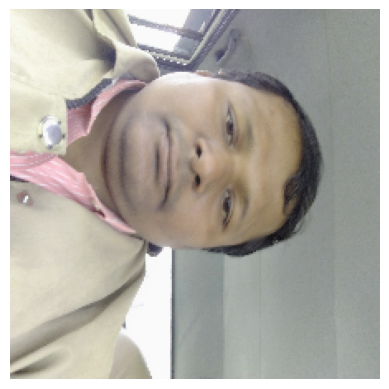

In [ ]:
visual_the_sample(Base_path_to_datas_to_train,76,_transform=train_transform)



<div class="alert alert-success" style="background-color: #3498db; color: #fff; text-align: center; border: 2px solid #2980b9; border-radius: 10px; padding: 15px; position: relative;">
    <h1 style="font-family: 'Arial', sans-serif; font-size: 24px; margin-bottom: 10px;">Создание загрузчика и визуализация данных</h1>
    <h1 style="font-family: 'Arial', sans-serif; font-size: 24px;">Creating a loader and visualizing data</h1>
</div>


## Creating a loader and visualizing data / Создание загрузчика и визуализация данных


In [ ]:
train_loader,validation_loader,test_loader=get_loaders(Bath_size,Base_path_to_datas_to_train,Base_path_to_datas_to_val,Num_workers,PIN_MEMORY,_transform_train=train_transform,_transform_test=test_transform,split_val=[0.7,0.2,0.1])

Number of train samples : 176
Number of val samples : 44
Number of test samples : 80


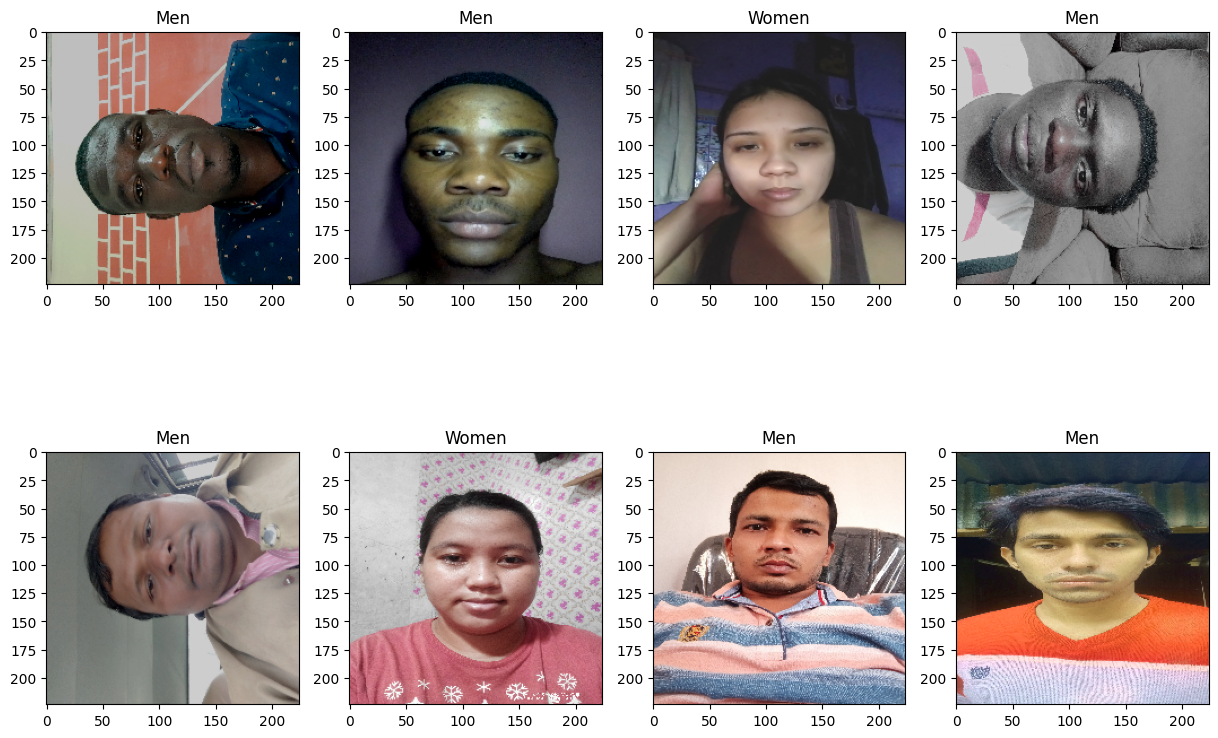

In [ ]:
images,labels=next(iter(train_loader))
fig,axis=plt.subplots(2,4,figsize=(15,10))

for i,ax in enumerate(axis.flat):
    with torch.no_grad():
        npimg=images[i].numpy()
        npimg=np.transpose(npimg,(1,2,0))
        label=labels[i]
        ax.imshow(npimg)
        ax.set(title=f'{clas_of_img[label.item()]}')



<div class="alert alert-success" style="background-color: #3498db; color: #fff; text-align: center; border: 2px solid #2980b9; border-radius: 10px; padding: 15px; position: relative;">
    <h1 style="font-family: 'Arial', sans-serif; font-size: 24px; margin-bottom: 10px;">Обучим модели</h1>
    <h1 style="font-family: 'Arial', sans-serif; font-size: 24px;">Let's train the models</h1>
</div>

## Let's train the models /Обучим модели


In [ ]:
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
device ='cuda' if torch.cuda.is_available() else 'cpu'
#========================================================
resnet_18 = get_resnet_18( num_classes = 5,array_for_model = [1000]).to(device=device)
resnet_50 = get_resnet_50( num_classes = 5,array_for_model = [1000]).to(device=device)
resnet_101 = get_resnet_101( num_classes = 5,array_for_model = [1000]).to(device=device)

<ipython-input-8-b44157d9e84e>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
optimizer_resnet_101 = optim.Adam(resnet_101.fc.parameters(), lr=Learn_rate,betas=(0.9,0.999),weight_decay = 1e-5)#, weight_decay=0.0001
optimizer_resnet_18  = optim.Adam(resnet_18.fc.parameters(), lr=Learn_rate,betas=(0.9,0.999),weight_decay = 1e-5)
optimizer_resnet_50  = optim.Adam(resnet_50.fc.parameters(), lr=Learn_rate,betas=(0.9,0.999),weight_decay = 1e-5)

optimizer_vgg16 = optim.Adam(vgg16.classifier.parameters(), lr=Learn_rate,betas=(0.9,0.999),weight_decay = 1e-5)
optimizer_vgg11 = optim.Adam(vgg11.classifier.parameters(), lr=Learn_rate,betas=(0.9,0.999),weight_decay = 1e-5)


scheduler_resnet_18 = lr_scheduler.StepLR(optimizer_resnet_18, step_size=5, gamma=0.1)
scheduler_resnet_50 = lr_scheduler.StepLR(optimizer_resnet_50, step_size=5, gamma=0.1)
scheduler_resnet_101 = lr_scheduler.StepLR(optimizer_resnet_101, step_size=5, gamma=0.1)

scheduler_vgg11 = lr_scheduler.StepLR(optimizer_vgg11, step_size=5, gamma=0.1)
scheduler_vgg16 = lr_scheduler.StepLR(optimizer_vgg16, step_size=5, gamma=0.1)




  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.9264
Точность на train/(Accuracy on train): 0.7386
Полнота на train/(Recall on train): 0.7386
Точность на valid/(Accuracy on valid): 0.7083
Полнота на valid/(Recall on valid): 0.7727
Точность на test/(Accuracy on test): 0.7500
Полнота на test/(Recall on test): 0.7500
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=0/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.4663
Точность на train/(Accuracy on train): 0.8466
Полнота на train/(Recall on train): 0.8466
Точность на valid/(Accuracy on valid): 0.7292
Полнота на valid/(Recall on valid): 0.7955
Точность на test/(Accuracy on test): 0.7125
Полнота на test/(Recall on test): 0.7125
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=1/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.5071
Точность на train/(Accuracy on train): 0.8580
Полнота на train/(Recall on train): 0.8580
Точность на valid/(Accuracy on valid): 0.7292
Полнота на valid/(Recall on valid): 0.7955
Точность на test/(Accuracy on test): 0.8000
Полнота на test/(Recall on test): 0.8000
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=2/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.4640
Точность на train/(Accuracy on train): 0.8693
Полнота на train/(Recall on train): 0.8693
Точность на valid/(Accuracy on valid): 0.7083
Полнота на valid/(Recall on valid): 0.7727
Точность на test/(Accuracy on test): 0.7625
Полнота на test/(Recall on test): 0.7625
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=3/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.4453
Точность на train/(Accuracy on train): 0.8920
Полнота на train/(Recall on train): 0.8920
Точность на valid/(Accuracy on valid): 0.7500
Полнота на valid/(Recall on valid): 0.8182
Точность на test/(Accuracy on test): 0.8125
Полнота на test/(Recall on test): 0.8125
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=4/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.4218
Точность на train/(Accuracy on train): 0.9091
Полнота на train/(Recall on train): 0.9091
Точность на valid/(Accuracy on valid): 0.6875
Полнота на valid/(Recall on valid): 0.7500
Точность на test/(Accuracy on test): 0.7750
Полнота на test/(Recall on test): 0.7750
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=5/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.3474
Точность на train/(Accuracy on train): 0.8864
Полнота на train/(Recall on train): 0.8864
Точность на valid/(Accuracy on valid): 0.6250
Полнота на valid/(Recall on valid): 0.6818
Точность на test/(Accuracy on test): 0.8000
Полнота на test/(Recall on test): 0.8000
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=6/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.3924
Точность на train/(Accuracy on train): 0.8977
Полнота на train/(Recall on train): 0.8977
Точность на valid/(Accuracy on valid): 0.7500
Полнота на valid/(Recall on valid): 0.8182
Точность на test/(Accuracy on test): 0.8125
Полнота на test/(Recall on test): 0.8125
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=7/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.3481
Точность на train/(Accuracy on train): 0.8693
Полнота на train/(Recall on train): 0.8693
Точность на valid/(Accuracy on valid): 0.7708
Полнота на valid/(Recall on valid): 0.8409
Точность на test/(Accuracy on test): 0.8000
Полнота на test/(Recall on test): 0.8000
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=8/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.3823
Точность на train/(Accuracy on train): 0.9148
Полнота на train/(Recall on train): 0.9148
Точность на valid/(Accuracy on valid): 0.7292
Полнота на valid/(Recall on valid): 0.7955
Точность на test/(Accuracy on test): 0.7875
Полнота на test/(Recall on test): 0.7875
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=9/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.3387
Точность на train/(Accuracy on train): 0.9148
Полнота на train/(Recall on train): 0.9148
Точность на valid/(Accuracy on valid): 0.7500
Полнота на valid/(Recall on valid): 0.8182
Точность на test/(Accuracy on test): 0.7875
Полнота на test/(Recall on test): 0.7875
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=10/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.3370
Точность на train/(Accuracy on train): 0.9205
Полнота на train/(Recall on train): 0.9205
Точность на valid/(Accuracy on valid): 0.7083
Полнота на valid/(Recall on valid): 0.7727
Точность на test/(Accuracy on test): 0.8000
Полнота на test/(Recall on test): 0.8000
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=11/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.3684
Точность на train/(Accuracy on train): 0.9205
Полнота на train/(Recall on train): 0.9205
Точность на valid/(Accuracy on valid): 0.7708
Полнота на valid/(Recall on valid): 0.8409
Точность на test/(Accuracy on test): 0.7875
Полнота на test/(Recall on test): 0.7875
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=12/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.3803
Точность на train/(Accuracy on train): 0.9205
Полнота на train/(Recall on train): 0.9205
Точность на valid/(Accuracy on valid): 0.6875
Полнота на valid/(Recall on valid): 0.7500
Точность на test/(Accuracy on test): 0.8125
Полнота на test/(Recall on test): 0.8125
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=13/15^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/22 [00:00<?, ?it/s]

on Epoch  Loss: 0.3329
Точность на train/(Accuracy on train): 0.9432
Полнота на train/(Recall on train): 0.9432
Точность на valid/(Accuracy on valid): 0.7917
Полнота на valid/(Recall on valid): 0.8636
Точность на test/(Accuracy on test): 0.8125
Полнота на test/(Recall on test): 0.8125
^^^^^^^^^^^^^^^^^^^^^^^^^epoch=14/15^^^^^^^^^^^^^^^^^^^^^^^^^


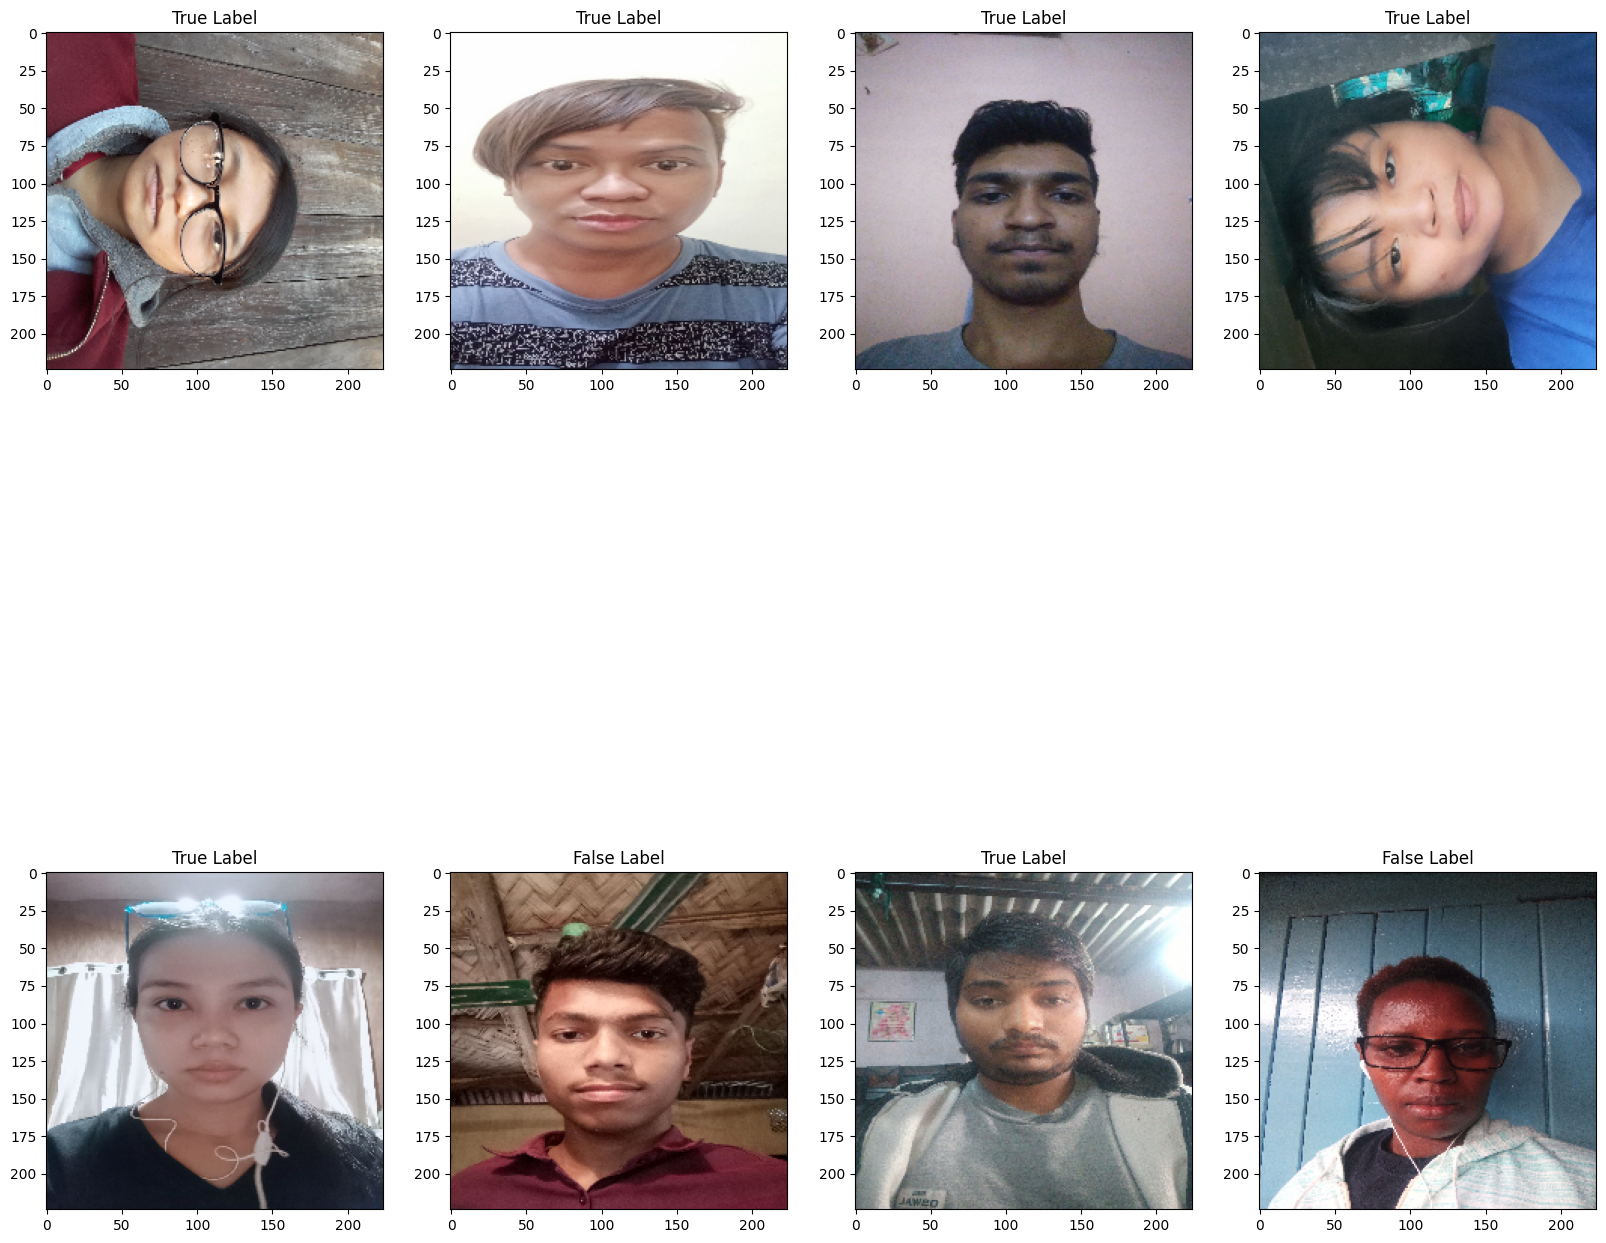

In [ ]:
train_for_epoch(Num_epoch,
                resnet_18,
                optimizer_resnet_18,
                loss_fn,
                scheduler_resnet_18,
                train_loader,
                validation_loader,
                test_loader,
                results_dict,
                'resnet_18' )

In [ ]:
train_for_epoch(Num_epoch,
                resnet_50,
                optimizer_resnet_50,
                loss_fn,
                scheduler_resnet_50,
                train_loader,
                validation_loader,
                test_loader,
                results_dict,
                'resnet_50' )

## Check results / Проверка результатов

ValueError: x and y must have same first dimension, but have shapes (15,) and (7,)

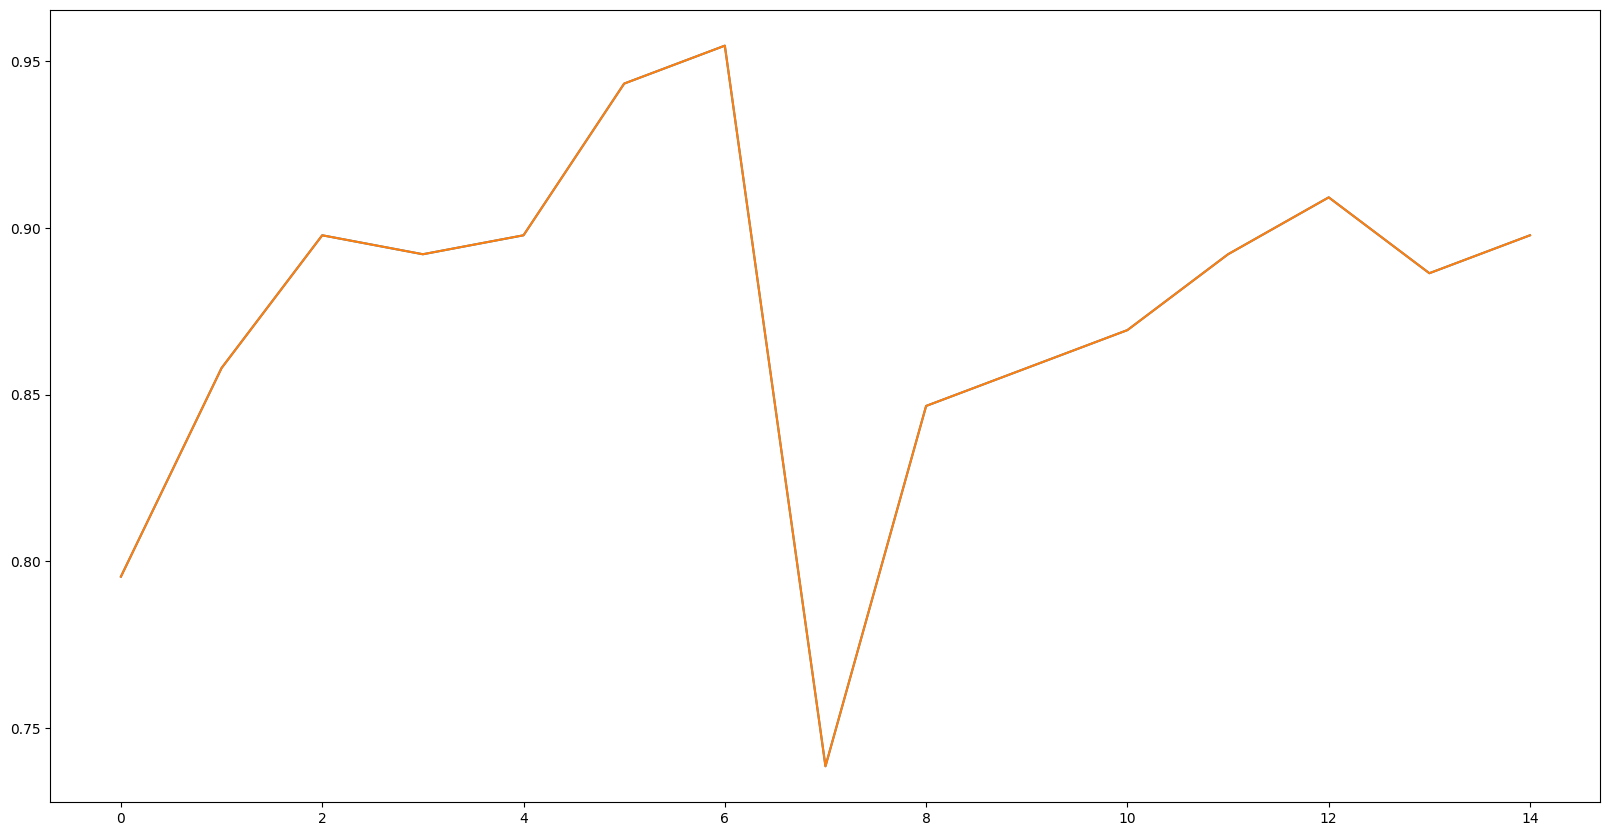

In [ ]:
draw_graph(results_dict,modeli)

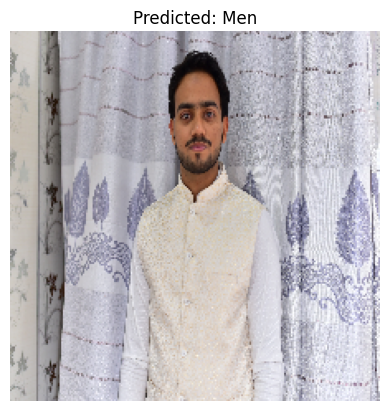

In [ ]:
# prompt: test on image from user given path

import matplotlib.pyplot as plt
import numpy as np
def test_single_image(model, image_path, transform, device, class_labels):
  """
  Tests a single image from a given path using the provided model.

  Args:
    model: The trained PyTorch model.
    image_path: The path to the image file.
    transform: The Albumentations transform to apply to the image.
    device: The device to run the inference on ('cuda' or 'cpu').
    class_labels: A dictionary mapping class indices to class names.
  """
  model.eval()

  try:
    image = np.array(Image.open(image_path).convert('RGB'))

    if transform:
      augmentations = transform(image=image)
      image = augmentations['image'].unsqueeze(0).to(device) # Add batch dimension and move to device
    else:
      image = torch.from_numpy(np.transpose(image, (2, 0, 1))).unsqueeze(0).to(device) # Move to device


    with torch.no_grad():
      preds = torch.sigmoid(model(image))
      _, predicted_class_index = torch.max(preds, dim=1)
      predicted_class_name = class_labels[predicted_class_index.item()]

    plt.imshow(np.transpose(image.squeeze().cpu().numpy(), (1, 2, 0)))
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

  except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
  except Exception as e:
    print(f"An error occurred: {e}")

# Example usage:
# Replace 'path/to/your/image.jpg' with the actual path to your image file
image_to_test_path = '/content/1000001962.jpg'

# Assuming resnet_18 is one of your trained models and exists
# If you trained other models, replace resnet_18 with the desired model variable
# Make sure the model is loaded or already in memory from previous training.
# For demonstration, let's use the resnet_18 model defined in your preceding code.

# If you want to test another model, uncomment and use it:
# model_to_test = resnet_50
# model_to_test = resnet_101
# model_to_test = vgg11
# model_to_test = vgg16
model_to_test = resnet_18 # Using resnet_18 as an example

test_single_image(model_to_test, image_to_test_path, test_transform, device, clas_of_img)


In [ ]:
# prompt: export pth and also download to pc. why there are multiple rsenet _ 18 pth please see. how to get one pth only. names are like /content/trained_models/pytorch_resnet_18-e0.pth

import os
from google.colab import files

# Define the directory where the trained models are saved
model_dir = '/content/trained_models'

# List all files in the directory
all_files = os.listdir(model_dir)

# Filter for resnet_18 pth files
resnet18_pth_files = [f for f in all_files if f.startswith('pytorch_resnet_18') and f.endswith('.pth')]

print(f"Found {len(resnet18_pth_files)} resnet_18 pth files:")
for f in resnet18_pth_files:
  print(f)

# If you want to keep only the last saved resnet_18 model (based on epoch number),
# you can sort the list and keep the last one.
if resnet18_pth_files:
  # Sort the files by epoch number (assuming the format is consistent)
  resnet18_pth_files.sort(key=lambda x: int(x.split('-e')[1].split('.')[0]))

  # The last file in the sorted list is the one from the last epoch
  last_resnet18_model = resnet18_pth_files[-1]
  print(f"\nKeeping only the latest model: {last_resnet18_model}")

  # You can optionally remove the other resnet_18 pth files
  for f in resnet18_pth_files[:-1]:
    os.remove(os.path.join(model_dir, f))
    print(f"Removed: {f}")

  # Define the path to the final model file
  final_model_path = os.path.join(model_dir, last_resnet18_model)

  # Download the final model to your PC
  print(f"\nDownloading {last_resnet18_model} to your PC...")
  files.download(final_model_path)
else:
  print("\nNo resnet_18 pth files found to export or download.")


Found 1 resnet_18 pth files:
pytorch_resnet_18-e14.pth

Keeping only the latest model: pytorch_resnet_18-e14.pth



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully loaded model weights from gender_detection_model.pth


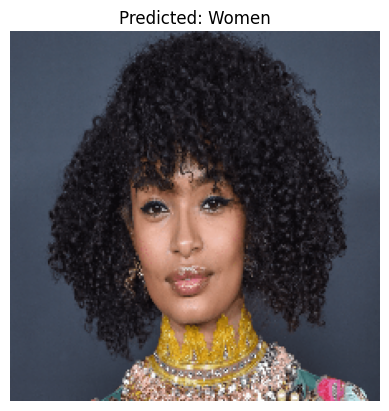

In [ ]:
# prompt: using pytorch_resnet_18-e14.pth detect image from user given path

import matplotlib.pyplot as plt
import numpy as np
def detect_image_from_path(model, image_path, transform, device, class_labels):
  """
  Detects and classifies an image from a user-given path using the provided model.

  Args:
    model: The trained PyTorch model.
    image_path: The path to the image file.
    transform: The Albumentations transform to apply to the image (should match training/testing).
    device: The device to run the inference on ('cuda' or 'cpu').
    class_labels: A dictionary mapping class indices to class names.
  """
  model.eval() # Set the model to evaluation mode

  try:
    # Check if the file exists
    if not os.path.exists(image_path):
      print(f"Error: Image file not found at {image_path}")
      return

    image = np.array(Image.open(image_path).convert('RGB'))

    if transform:
      augmentations = transform(image=image)
      image_tensor = augmentations['image'].unsqueeze(0).to(device) # Add batch dimension and move to device
    else:
      # If no transform is provided, resize and convert to tensor manually
      image_resized = cv2.resize(image, (Size_of_img, Size_of_img))
      image_tensor = torch.from_numpy(np.transpose(image_resized, (2, 0, 1))).unsqueeze(0).to(device).float() / 255.0 # Add batch, move, normalize

    with torch.no_grad():
      # Assuming your model outputs raw logits, apply sigmoid or softmax depending on your training
      # Based on the preceding code, sigmoid is used for predictions in check_accuracy
      # If your model was trained with CrossEntropyLoss and does not have a final sigmoid/softmax layer,
      # you might not need sigmoid here for classification. Let's assume raw logits for now.
      outputs = model(image_tensor)

      # For binary classification (like gender), often sigmoid is used on a single output,
      # or softmax on two outputs. The preceding code uses torch.sigmoid and then torch.max,
      # which suggests a multi-class setup where `preds = torch.sigmoid(model(x))` might be
      # followed by `_, preds = torch.max(preds, dim=1)`. Let's stick to that pattern for prediction.

      preds = torch.sigmoid(outputs) # Apply sigmoid

      _, predicted_class_index = torch.max(preds, dim=1)
      predicted_class_name = class_labels[predicted_class_index.item()]

    # Display the image with the prediction
    plt.imshow(np.transpose(image_tensor.squeeze().cpu().numpy(), (1, 2, 0)))
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

  except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
  except Exception as e:
    print(f"An error occurred during image detection: {e}")

# --- How to use the function ---
# Assuming 'resnet_18' is your loaded model and 'test_transform' is defined as in the preceding code.
# You'll need the path to the trained model file.
# Let's assume the model is saved as 'pytorch_resnet_18-e14.pth' in the current directory
# or wherever your training saved it.

# Load the trained model state dictionary
model_path = 'gender_detection_model.pth' # Replace with the actual path to your .pth file

# Instantiate the model architecture (needs to match the one used for training)
# Based on your preceding code:
model_for_detection = get_resnet_18( num_classes = 5,array_for_model = [1000]).to(device=device)

# Load the saved state dictionary into the model
try:
  model_for_detection.load_state_dict(torch.load(model_path, map_location=device))
  print(f"Successfully loaded model weights from {model_path}")
except FileNotFoundError:
  print(f"Error: Model file not found at {model_path}. Please make sure the .pth file is in the correct location.")
  # You might want to exit or handle this error appropriately
  exit() # Exit the cell execution if the model file is not found

# Get the image path from the user
image_path_to_detect = "/content/girl2.png"

# Call the detection function
detect_image_from_path(model_for_detection, image_path_to_detect, test_transform, device, clas_of_img)

